Factorisation de code et creation du fonction mumford shah

In [23]:
import sys
sys.path.append('../..')

In [24]:
import numpy




import lasp.thresholding
def shrink2(x, y, lamda):
    # Donne exactement les résultats de matlab
    return lasp.thresholding.multidimensional_soft(
        numpy.array([x, y]), lamda
    )

## CMST_SegMain

In [16]:
import lasp.filters.linear
import lasp.noise
import lasp.io


import pathlib

import scipy.signal
import scipy.io

import matplotlib.pyplot

Img_original = numpy.array(
    matplotlib.pyplot.imread('Boats.bmp'),
    dtype=numpy.double
)

h = lasp.filters.linear.gaussian_filter(size=7, sigma=3)

Img_blurred = numpy.array(
    scipy.signal.convolve2d(Img_original, h, mode='same'),
    dtype=numpy.double
)

Img = numpy.copy(Img_blurred)
#Img = lasp.noise.awgn(Img_blurred, snr=20)

In [17]:
path = pathlib.Path('PyVsMat/CMST_SegDeblur')
lasp.io.save(Img, path / 'input.png')
lasp.io.save(h, path / 'kernel.png')

# Save img input and kernel as array for matlab
datas_matlab = {}
datas_matlab['input'] = Img
datas_matlab['kernel'] = h
scipy.io.savemat(path / 'datas_for_matlab.mat', datas_matlab)

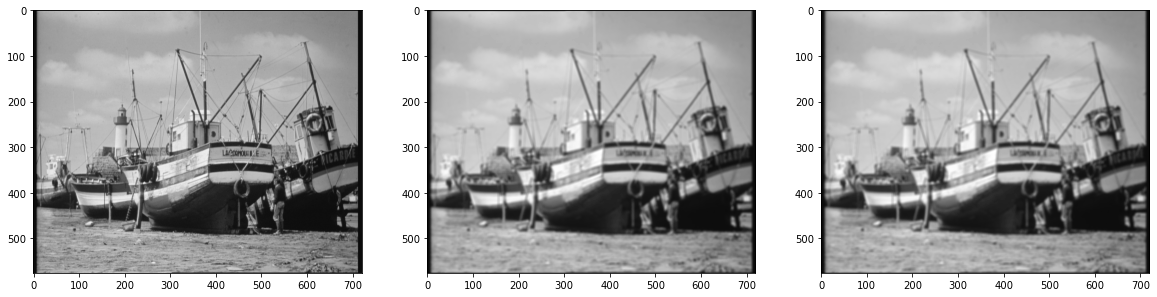

In [18]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(Img_original, cmap='gray')
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(Img_blurred, cmap='gray')
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(Img, cmap='gray')

In [19]:
import lasp.differential
def mumford_shah(
    img: numpy.ndarray, 
    h: numpy.ndarray, 
    alpha: float,
    beta: float,
    sigma: float,
    nb_iterations: int,
    tolerance: float
) -> numpy.ndarray:

    Dx = lasp.differential.dx
    Dy = lasp.differential.dy
    Dxt = lasp.differential.dxT
    Dyt = lasp.differential.dyT

    nb_rows, nb_cols = img.shape
    # INitialization
    u = numpy.copy(img) 
    wx=numpy.zeros_like(img)
    wy=numpy.zeros_like(img)
    bx=numpy.zeros_like(img)
    by=numpy.zeros_like(img)

    # Build kernel
    uker = numpy.zeros_like(img)
    uker[0, 0] = 4
    uker[0, 1] = -1
    uker[1, 0] = -1
    uker[nb_rows-1, 0] = -1
    uker[0, nb_cols-1] = -1

    # Construct the deblur operator
    # flt_blur = numpy.array(numpy.load('motion_15_90.npy'))
    flt_blur = h
    xLen_flt, yLen_flt = flt_blur.shape
    xLen, yLen = img.shape
    ope_blur = numpy.zeros((xLen, yLen))
    ope_blur[0:xLen_flt, 0:yLen_flt] = flt_blur

    # Shift deblur operator
    xLen_flt_1 = int(numpy.round(xLen_flt/2))
    yLen_flt_1 = int(numpy.round(yLen_flt/2))
    ope_blur_1 = numpy.roll(ope_blur, (1-xLen_flt_1, 1-yLen_flt_1), [0, 1])

    uker = alpha*numpy.conj(numpy.fft.fft2(ope_blur_1))*numpy.fft.fft2(ope_blur_1) \
        + (beta+sigma) * numpy.fft.fft2(uker)

    rhs1fft = alpha*numpy.conj(numpy.fft.fft2(ope_blur_1))*numpy.fft.fft2(img)

    # error_function = []


    for i in range(0, nb_iterations):

        rhs2 = sigma*Dxt(wx-bx)+sigma*Dyt(wy-by)
        rhsfft = rhs1fft + numpy.fft.fft2(rhs2)

        u0=numpy.copy(u)
        
        u = numpy.real(numpy.fft.ifft2(rhsfft / uker))    

        err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')
        # error_function.append(err)
        if i%10 == 0:
            print('Iterations: {} ! \t error is: {}'.format(i, err))

        if err < tolerance:
            print('All iterations: {}'.format(i))
            break
        
        temp1 = Dx(u)+bx
        temp2 = Dy(u)+by

        # wx, wy = shrink2_v1(temp1, temp2, 1/SIGMA)
        wx, wy = shrink2(temp1, temp2, 1/sigma)

        bx=bx+Dx(u)-wx
        by=by+Dy(u)-wy

    min_u = numpy.min(u)
    max_u = numpy.max(u)
    u = (u-min_u) / (max_u-min_u)

# mat 5x5 alétaoire
# load(mat)
# difference entre les 2


In [20]:
import numpy
import numpy.linalg


Img = Img - numpy.min(Img)
Img = Img / numpy.max(Img)

LAMBDA = 100
MU = 1
SIGMA = 2

mumford_shah(Img, h, 100, 1, 2, 300, 10**(-4))

Iterations: 0 ! 	 error is: 0.42792694943848686
Iterations: 10 ! 	 error is: 0.0025102696591094062
Iterations: 20 ! 	 error is: 0.0008290666205331598
Iterations: 30 ! 	 error is: 0.0004344710073994916
Iterations: 40 ! 	 error is: 0.00025853984444404747
Iterations: 50 ! 	 error is: 0.00018258583010554252
Iterations: 60 ! 	 error is: 0.00014008200433838537
Iterations: 70 ! 	 error is: 0.00011259907673813513
All iterations: 78


In [21]:
# x = numpy.arange(0, NB_ITERATIONS)
# y = error_function
# matplotlib.pyplot.xlabel(xlabel='Nb iteration')
# matplotlib.pyplot.ylabel(ylabel='Error')
# _ = matplotlib.pyplot.plot(x[0:20], y[0:20])
# _ = matplotlib.pyplot.plot(x[0:20], y[0:20], 'or')

In [22]:
print(y[0:20])

NameError: name 'y' is not defined

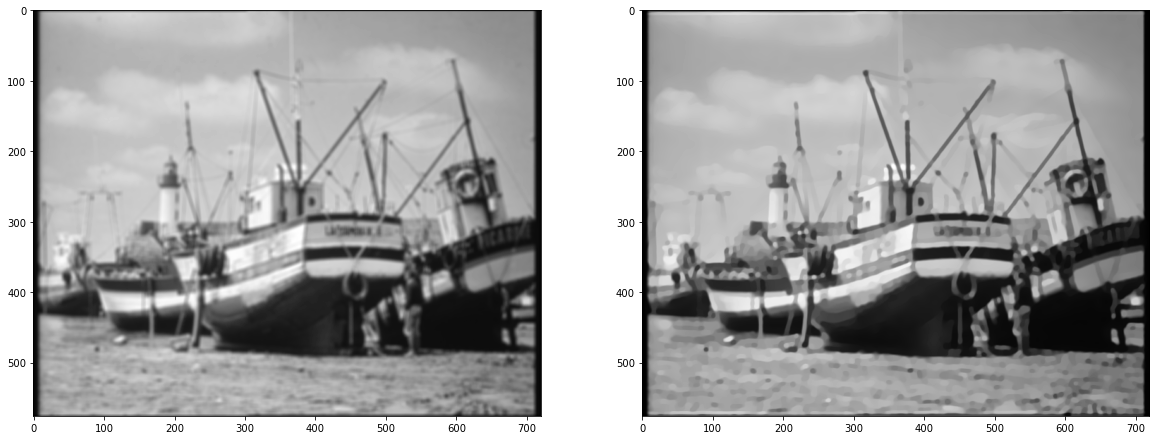

In [ ]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.imshow(Img, cmap='gray')
matplotlib.pyplot.subplot(1, 2, 2)

matplotlib.pyplot.imshow(numpy.real(u), cmap='gray')
lasp.io.save(u, path / 'output.png')

In [ ]:
# import scipy.io
# a = scipy.io.matlab.loadmat('uu.mat')
# mat_res = numpy.array(a['uu'])
# matplotlib.pyplot.imshow(mat_res, cmap='gray')
# numpy.max(numpy.abs(mat_res-u))

In [ ]:
# import lasp.metrics
# lasp.metrics.mean_squared_error(mat_res, u)

In [ ]:
# matplotlib.pyplot.imshow(numpy.abs(mat_res-u), cmap='gray')